In [1]:

import pickle
import csv
import numpy as np
import glob
from sys import exit
from sklearn import preprocessing;
import matplotlib.pyplot as plt

In [2]:
PT_arrays = [];
PF_arrays = [];
LC_arrays = [];
LC_all_arrays = [];
for condition_ind in [0,1,2,3]:
        PT_filename = 'SRI_collab/PT_Cond' + repr(condition_ind)+'.csv';
        PF_filename = 'SRI_collab/PF_Cond' + repr(condition_ind)+'.csv';
        LC_filename = 'SRI_collab/LC_Cond' + repr(condition_ind)+'.csv';
        #LC_all_filename = 'SRI_collab/LC_all_Cond' + repr(condition_ind)+'.csv';

        with open(PT_filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            iter = 0;
            all_rows = [];
            for row in spamreader:
                if iter>1:
                    try:
                        row = [np.float(elem) for elem in row]
                        all_rows.append(row)
                    except:
                        row;
                    
                iter = iter+1;
            PT_arrays.append(np.asarray(all_rows));
        
        with open(PF_filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            iter = 0;
            all_rows = [];
            for row in spamreader:
                if iter>1:
                    try:
                        row = [np.float(elem) for elem in row]
                        all_rows.append(row)
                    except:
                        row;
                    
                iter = iter+1;
            PF_arrays.append(np.asarray(all_rows));
        with open(LC_filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            iter = 0;
            all_rows = [];
            for row in spamreader:
                if iter>1:
                    try:
                        row = [np.float(elem) for elem in row]
                        all_rows.append(row)
                    except:
                        row;
                    
                iter = iter+1;
            LC_arrays.append(np.asarray(all_rows));
#         with open(LC_all_filename, newline='') as csvfile:
#             spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#             iter = 0;
#             all_rows = [];
#             for row in spamreader:
#                 if iter>1:
#                     try:
#                         row = [np.float(elem) for elem in row]
#                         all_rows.append(row)
#                     except:
#                         row;
                    
#                 iter = iter+1;
#             LC_all_arrays.append(np.asarray(all_rows));

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    diff_array = (np.abs(array - value));
    idx = diff_array.argmin();
    return idx;


In [4]:
PF_arrays


[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [5]:

#f_PF_arrays = [];
f_PT_arrays =[];
for array_ind in range(0,len(LC_arrays)):
    this_array= LC_arrays[array_ind];
    time_column = this_array[:,0]
#    this_PF_array = PF_arrays[array_ind];
    this_PT_array = PT_arrays[array_ind];
#    filtered_PF_array = [];
    filtered_PT_array = [];
    for time in time_column:
#        array_idx = find_nearest(this_PF_array[:,0],time)
#        filtered_PF_array.append(this_PF_array[array_idx,:]);

        array_idx = find_nearest(this_PT_array[:,0],time)
        filtered_PT_array.append(this_PT_array[array_idx,:]);
#    f_PF_arrays.append(filtered_PF_array);
    f_PT_arrays.append(filtered_PT_array);

In [6]:
from sklearn import preprocessing;

this_LC_scaler = preprocessing.MinMaxScaler()
#this_LC_all_scaler = preprocessing.MinMaxScaler()
#this_PF_scaler = preprocessing.MinMaxScaler()
this_PT_scaler = preprocessing.MinMaxScaler()

LC_stacked =np.vstack(LC_arrays);
#LC_all_stacked =np.vstack(LC_all_arrays);
#PF_stacked = np.vstack(f_PF_arrays)
PT_stacked = np.vstack(f_PT_arrays)

this_LC_scaler.fit(LC_stacked)
#this_LC_all_scaler.fit(LC_all_stacked)
#this_PF_scaler.fit(PF_stacked)
this_PT_scaler.fit(PT_stacked)

t_LC_arrays = [this_LC_scaler.transform(elem) for elem in LC_arrays];
#t_LC_all_arrays = [this_LC_all_scaler.transform(elem) for elem in LC_all_arrays];
#t_PF_arrays = [this_PF_scaler.transform(elem) for elem in f_PF_arrays];
t_PT_arrays = [this_PT_scaler.transform(elem) for elem in f_PT_arrays];

In [7]:
#y_out = np.vstack(t_LC_arrays)
#u_out = np.vstack(t_PT_arrays);
#plt.plot(y_out[:,0],y_out[:,:],marker='o')
#plt.plot(u_out[:,0],u_out[:,5],marker='o')
for cond_ind in [0,1,2,3]:
    LCp = np.vstack([elem[0:-1,1:] for elem in t_LC_arrays]);
    #LCallp = np.vstack([elem[0:-1,1:] for elem in t_LC_all_arrays]);
    PTp = np.vstack([elem[0:-1,1:] for elem in t_PT_arrays]);
    LCf = np.vstack([elem[1:,1:] for elem in t_LC_arrays]);
    #LCallf =  np.vstack([elem[1:,1:] for elem in t_LC_all_arrays]);
    PTf = np.vstack([elem[1:,1:] for elem in t_PT_arrays]);
Yp_global = LCp;
Yf_global = LCf;
Ywhole = np.vstack(t_LC_arrays);
u_global = PTp;

In [8]:
Yp_global.shape

(32, 7)

In [9]:
picklefile_path = './koopman_data/SRI_ribo.pickle';
picklefile=open(picklefile_path,'wb')
pickle.dump([Yp_global,Yf_global,u_global],picklefile)
picklefile.close()

In [10]:
from cvxpy import Minimize
from cvxpy import Minimize, Problem, Variable,norm1,installed_solvers,lambda_max;
from cvxpy import norm as cvxpynorm;
import cvxpy

def calc_Input_Koopman(Yf,Yp,Up,flag=1,lambda_val=0.0,PsiDelta_Mat=[]):
    solver_instance = cvxpy.SCS;
    Ki = None;
    if flag==1: # moore penrose inverse, plain ol' least squares input-Koopman
        #Yp_inv = np.dot(np.transpose(Yp_final), np.linalg.inv( np.dot(Yp_final,np.transpose(Yp_final)) )   );
        Yfprime = Yf-np.dot(Kol,Yp)
        Up_inv = np.linalg.pinv(Up);
        Ki = np.dot(Yfprime,Up_inv);
        

    if flag ==2: # cvx optimization approach - L2 + L1 lasso 
        norm1_term = 0.0;
        all_col_handles = [None]*Up.shape[0]

        for i in range(0,Up.shape[0]):
            all_col_handles[i] = Variable(shape=(Yf.shape[0],1)) ;#Variable(shape=(Yf.shape[0],1) );

        operator = cvxpy.hstack(all_col_handles);
        
        all_Kol_col_handles = [None]*Yp.shape[0];
        for i in range(0,Yp.shape[0]):
            all_Kol_col_handles[i] = Variable(shape=(Yp.shape[0],1)); 
        ol_operator = cvxpy.hstack(all_Kol_col_handles);
        
        
        if len(PsiDelta_Mat) == 0:
            if (type(lambda_val) == np.float):
                norm1_term =lambda_val*(cvxpy.norm(ol_operator,p='fro')+cvxpy.norm(operator,p='fro'));
            else:
                lambda_val = np.reshape(lambda_val,(len(lambda_val),1));
                Unoise = np.tile(lambda_val,(1,Up.shape[1]))
                norm1_term = cvxpy.norm(cvxpy.matmul(operator,Unoise),p='fro');
        else:
            norm1_term = cvxpy.norm(cvxpy.matmul(operator,PsiDelta_Mat),p='fro');
        
        norm2_fit_term = cvxpy.norm(cvxpy.norm(Yf-ol_operator*Yp-operator*Up,p=2,axis=0),p=2);
        objective = Minimize(norm2_fit_term + norm1_term)
        constraints = [];
        prob = Problem(objective,constraints);
        result = prob.solve(verbose=True,solver=solver_instance,max_iters=np.int(1e7))#,reltol=1e-10,abstol=1e-10);
        print("[INFO]: Finished executing cvx solver, printing CVXPY problem status")
        print(prob.status);
        Ki = operator.value;
        Kx = ol_operator.value;
    return Kx,Ki;

In [11]:
Kx,Ki = calc_Input_Koopman(Yf_global.T,Yp_global.T,u_global.T,flag=2,lambda_val=0.01)


----------------------------------------------------------------------------
	SCS v2.1.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 2755
eps = 1.00e-04, alpha = 1.50, max_iters = 10000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 119, constraints m = 375
Cones:	soc vars: 375, soc blks: 35
Setup time: 7.82e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.65e+19  5.67e+19  1.00e+00 -3.62e+20  4.31e+19  2.17e+20  8.06e-03 
    60| 9.06e-06  1.29e-05  1.99e-06  1.33e+00  1.33e+00  9.92e-17  1.05e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time

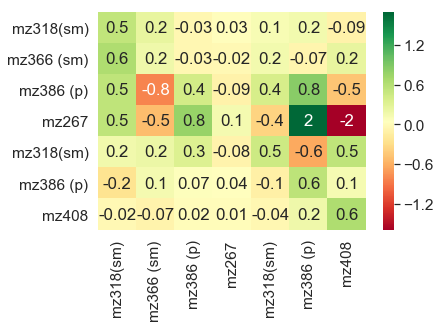

In [12]:
import seaborn as sns
this_ylabels = ['mz318(sm)','mz366 (sm)','mz386 (p)','mz267','mz318(sm)','mz386 (p)','mz408']
import matplotlib
sns.set(font_scale=1.4)
hm = sns.heatmap(Kx,xticklabels=this_ylabels,yticklabels=this_ylabels,cmap='RdYlGn',fmt='0.1g',annot=True)

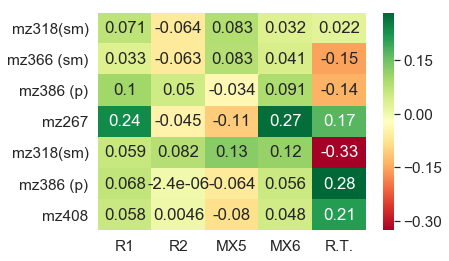

In [13]:

this_xlabels = ['R1','R2','MX5','MX6','R.T.']
sns.set(font_scale=1.4)
hm=sns.heatmap(Ki,xticklabels=this_xlabels,yticklabels=this_ylabels,cmap='RdYlGn',annot=True)